In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error

from loader import train_loader, val_loader, test_loader, scaler, df_train

In [2]:
class ConditionalForecastVAE(nn.Module):
    def __init__(self, window_size, num_series, static_dim, latent_dim=32, hidden_dim=128, dropout=0.1, output_dim=2):
        """
        Mô hình VAE điều kiện:
          - Encoder nhận đầu vào là: [flatten(x_seq); static_features]
          - Decoder nhận đầu vào là: [latent vector; static_features]
          - Thêm skip connection từ flatten(x_seq) sang decoder.
        """
        super(ConditionalForecastVAE, self).__init__()
        self.window_size = window_size
        self.num_series = num_series
        self.static_dim = static_dim
        
        # Encoder input: flatten(x_seq) có kích thước window_size*num_series, concat với static features.
        self.encoder_input_dim = window_size * num_series + static_dim
        self.fc_enc = nn.Sequential(
            nn.Linear(self.encoder_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder input: latent vector concat static features.
        self.decoder_input_dim = latent_dim + static_dim
        self.fc_dec = nn.Sequential(
            nn.Linear(self.decoder_input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        # Skip connection: dựa trên flatten(x_seq)
        self.fc_skip = nn.Linear(window_size * num_series, hidden_dim)
        
        # Dự báo cuối cùng: kết hợp đầu ra của decoder và skip connection.
        self.final_fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def encode(self, x_seq, x_cal):
        batch_size = x_seq.size(0)
        x_seq_flat = x_seq.view(batch_size, -1)  # (batch, window_size*num_series)
        enc_input = torch.cat([x_seq_flat, x_cal], dim=1)  # (batch, encoder_input_dim)
        h = self.fc_enc(enc_input)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar, x_seq_flat  # trả về x_seq_flat để dùng cho skip connection
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, x_cal, skip):
        dec_input = torch.cat([z, x_cal], dim=1)  # (batch, decoder_input_dim)
        h_dec = self.fc_dec(dec_input)  # (batch, hidden_dim)
        skip_feat = self.fc_skip(skip)  # (batch, hidden_dim)
        combined = torch.cat([h_dec, skip_feat], dim=1)  # (batch, 2*hidden_dim)
        forecast = self.final_fc(combined)  # (batch, output_dim)
        return forecast
    
    def forward(self, x_seq, x_cal):
        mu, logvar, x_seq_flat = self.encode(x_seq, x_cal)
        z = self.reparameterize(mu, logvar)
        forecast = self.decode(z, x_cal, x_seq_flat)
        return forecast, mu, logvar


In [3]:
def vae_loss(recon_x, x_true, mu, logvar, kl_weight):
    recon_loss = nn.SmoothL1Loss()(recon_x, x_true)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kl_loss

In [4]:
model = ConditionalForecastVAE(window_size=30, num_series=2, static_dim=18, latent_dim=32, hidden_dim=128, dropout=0.1, output_dim=2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [5]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
kl_start = 0.0
kl_max = 0.001

In [6]:
num_epochs = 100
best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    kl_weight = min(kl_max, kl_max * (epoch / 50))  # annealing lên đến epoch 50
    for x_seq, x_cal, y in train_loader:
        x_seq = x_seq.to(device)
        x_cal = x_cal.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        forecast, mu, logvar = model(x_seq, x_cal)
        loss = vae_loss(forecast, y, mu, logvar, kl_weight)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * x_seq.size(0)
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x_seq, x_cal, y in val_loader:
            x_seq = x_seq.to(device)
            x_cal = x_cal.to(device)
            y = y.to(device)
            forecast, mu, logvar = model(x_seq, x_cal)
            loss = vae_loss(forecast, y, mu, logvar, kl_weight)
            running_val_loss += loss.item() * x_seq.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_losses.append(epoch_val_loss)
    
    scheduler.step(epoch_val_loss)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, KL Weight: {kl_weight:.6f}")
    
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        checkpoint = {
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': epoch_val_loss,
        }
        torch.save(checkpoint, 'checkpoints/VAE.pth')
        print(f"Best model updated at epoch {epoch+1} with validation loss {epoch_val_loss:.4f}")

Best model updated at epoch 1 with validation loss 0.1946
Best model updated at epoch 2 with validation loss 0.1685
Best model updated at epoch 3 with validation loss 0.1232
Best model updated at epoch 4 with validation loss 0.1064
Best model updated at epoch 5 with validation loss 0.0749
Best model updated at epoch 6 with validation loss 0.0621
Best model updated at epoch 8 with validation loss 0.0485
Best model updated at epoch 9 with validation loss 0.0474
Epoch [10/100], Train Loss: 0.0345, Val Loss: 0.0471, KL Weight: 0.000180
Best model updated at epoch 10 with validation loss 0.0471
Best model updated at epoch 11 with validation loss 0.0451
Best model updated at epoch 12 with validation loss 0.0407
Best model updated at epoch 13 with validation loss 0.0369
Best model updated at epoch 15 with validation loss 0.0332
Best model updated at epoch 18 with validation loss 0.0320
Best model updated at epoch 19 with validation loss 0.0316
Epoch [20/100], Train Loss: 0.0269, Val Loss: 0.0

In [7]:
def get_predictions(loader, model, device):
    model.eval()
    preds = []
    actuals = []
    with torch.no_grad():
        for x_seq, x_cal, y in loader:
            x_seq = x_seq.to(device)
            x_cal = x_cal.to(device)
            forecast, mu, logvar = model(x_seq, x_cal)
            preds.append(forecast.cpu().numpy())
            actuals.append(y.cpu().numpy())
    preds = np.concatenate(preds, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    return preds, actuals

train_preds, train_actuals = get_predictions(train_loader, model, device)
test_preds, test_actuals = get_predictions(test_loader, model, device)

# Giả sử scaler đã được fit trước đó; inverse transform để đưa về thang đo ban đầu
train_preds_inv = scaler.inverse_transform(train_preds)
train_actuals_inv = scaler.inverse_transform(train_actuals)
test_preds_inv = scaler.inverse_transform(test_preds)
test_actuals_inv = scaler.inverse_transform(test_actuals)

r2 = r2_score(test_actuals_inv, test_preds_inv)
mape = mean_absolute_percentage_error(test_actuals_inv, test_preds_inv)
rmse = np.sqrt(mean_squared_error(test_actuals_inv, test_preds_inv))
print(f"Test R-squared: {r2:.4f}")
print(f"Test MAPE: {mape:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test R-squared: 0.9557
Test MAPE: 0.3846
Test RMSE: 150960.2969


In [8]:
# Tính các chỉ số riêng cho Units và Revenue
r2_units = r2_score(test_actuals_inv[:, 0], test_preds_inv[:, 0])
mape_units = mean_absolute_percentage_error(test_actuals_inv[:, 0], test_preds_inv[:, 0])
rmse_units = np.sqrt(mean_squared_error(test_actuals_inv[:, 0], test_preds_inv[:, 0]))

print(f"Test Units R-squared: {r2_units:.4f}")
print(f"Test Units MAPE: {mape_units:.4f}")
print(f"Test Units RMSE: {rmse_units:.4f}")

r2_revenue = r2_score(test_actuals_inv[:, 1], test_preds_inv[:, 1])
mape_revenue = mean_absolute_percentage_error(test_actuals_inv[:, 1], test_preds_inv[:, 1])
rmse_revenue = np.sqrt(mean_squared_error(test_actuals_inv[:, 1], test_preds_inv[:, 1]))

print(f"Test Revenue R-squared: {r2_revenue:.4f}")
print(f"Test Revenue MAPE: {mape_revenue:.4f}")
print(f"Test Revenue RMSE: {rmse_revenue:.4f}")

Test Units R-squared: 0.9553
Test Units MAPE: 0.4436
Test Units RMSE: 27.3455
Test Revenue R-squared: 0.9561
Test Revenue MAPE: 0.3256
Test Revenue RMSE: 213490.1250


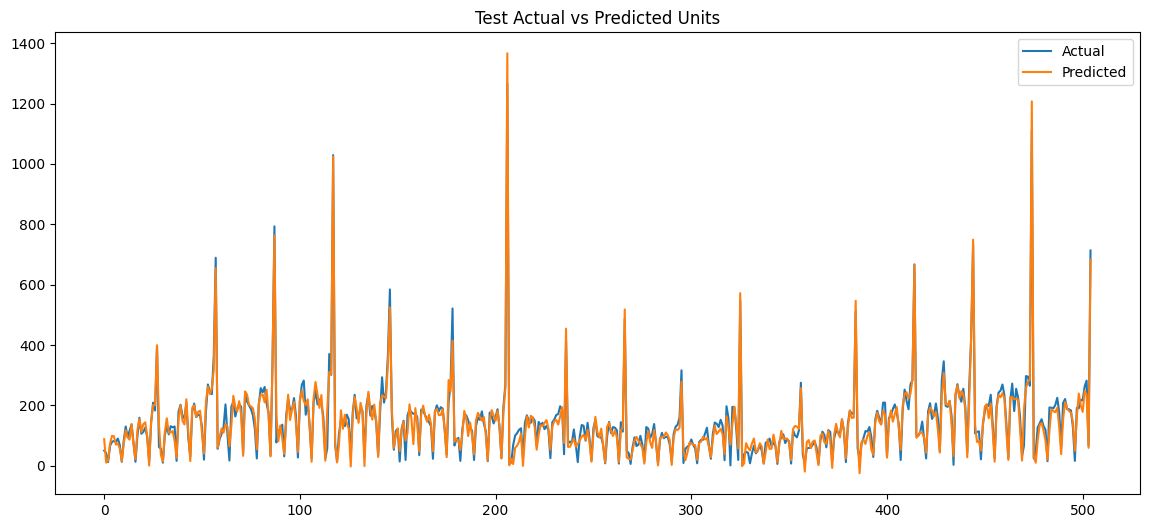

In [9]:
# Vẽ đồ thị dự báo và thực tế đối với Units
plt.figure(figsize=(14, 6))
plt.plot(test_actuals_inv[:, 0], label='Actual')
plt.plot(test_preds_inv[:, 0], label='Predicted')
plt.title('Test Actual vs Predicted Units')
plt.legend()
plt.show()

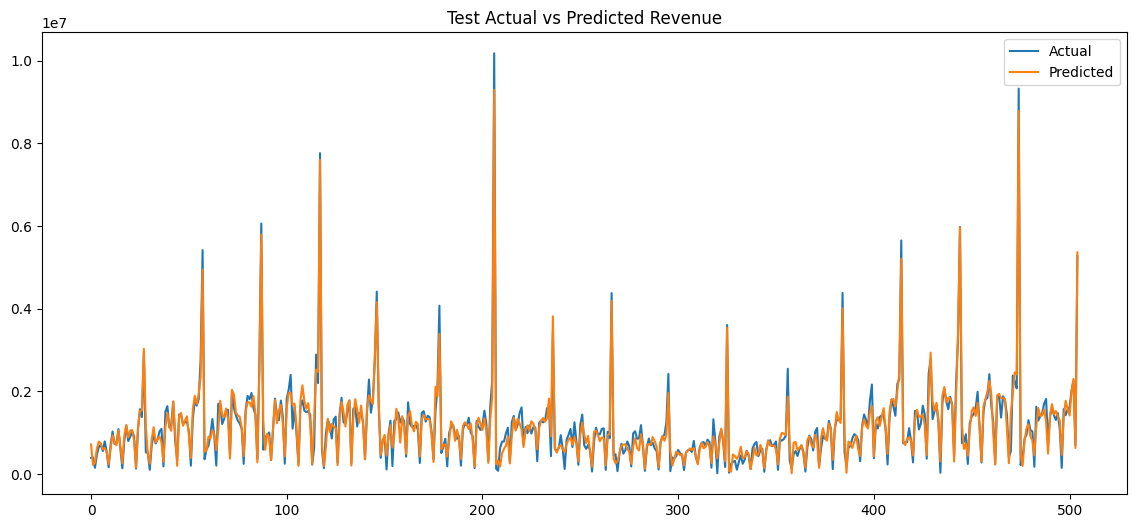

In [10]:
# Vẽ đồ thị dự báo và thực tế đối với Revenue
plt.figure(figsize=(14, 6))
plt.plot(test_actuals_inv[:, 1], label='Actual')
plt.plot(test_preds_inv[:, 1], label='Predicted')
plt.title('Test Actual vs Predicted Revenue')
plt.legend()
plt.show()